# HDFC - About Dataset
From the given data we need to predict if a person will pay loan or not if loan was sanctioned.

Train.csv - 17521*2395
2393 annoynamous columns
col1 - ID
col2 - class label

Test.csv - 20442*2394
    

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

from collections import Counter

from tqdm import tqdm
import os

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from matplotlib import pyplot

# Loading data

In [0]:
data = pd.read_csv("Train.csv")

In [8]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,Col23,Col24,Col25,Col26,Col27,Col28,Col29,Col30,Col31,Col32,Col33,Col34,Col35,Col36,Col37,Col38,Col39,Col40,...,Col2358,Col2359,Col2360,Col2361,Col2362,Col2363,Col2364,Col2365,Col2366,Col2367,Col2368,Col2369,Col2370,Col2371,Col2372,Col2373,Col2374,Col2375,Col2376,Col2377,Col2378,Col2379,Col2380,Col2381,Col2382,Col2383,Col2384,Col2385,Col2386,Col2387,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,RIGHGSN,1,1.086711e+04,8.648345e+03,1.576618e+04,2.890466e+04,5.273655e+03,2.346153e+04,1.285597e+04,2.871509e+04,9.114586e+03,3.043078e+04,9.293496,8.570479,10.063117,10.271758,0.548538,0.403366,NaN,NaN,1.486524,1.728324,0.993441,1.297050,0.137398,0.115987,0.260428,1.414214,1,1,1,1,1,1,0,6,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,214.0,214.0,68.0,22.0,22.0,7.0
1,RIMHI5ZGP,0,2.584312e+05,2.179633e+05,1.866287e+05,1.866287e+05,2.154519e+05,1.923615e+05,1.726538e+05,1.666974e+05,2.013518e+05,1.859404e+05,12.462385,12.280493,12.167132,12.136876,1.167898,2.676398,NaN,NaN,0.792123,0.934556,0.893203,0.966620,0.753892,0.808295,1.414214,NaN,1,1,3,4,4,0,4,5,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41.0,41.0,38.0,12.0,12.0,11.0
2,RIHOG1SZU,0,1.459355e+07,1.260060e+07,1.100315e+07,1.010315e+07,1.879882e+07,1.514035e+07,5.320778e+06,6.906324e+06,9.368338e+06,1.113330e+07,16.496090,16.749305,16.532874,16.128357,1.145182,2.203874,NaN,NaN,0.422264,0.498347,0.683582,0.735339,0.808115,0.776910,1.414214,NaN,3,3,4,12,4,0,2,4,NaN,1.0,NaN,NaN,...,1,0,1,0,1,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,378.0,378.0,310.0,21.0,21.0,16.0
3,RIHOLMQWU,0,6.727043e+05,8.181116e+05,6.794893e+05,6.794893e+05,8.257254e+05,7.605803e+05,3.577134e+05,4.236612e+05,4.304848e+05,4.065539e+05,13.419061,13.624018,13.541837,13.429097,1.204010,0.536304,NaN,NaN,0.437243,0.521341,0.623499,0.534531,-0.125829,0.388830,-1.414214,NaN,2,2,2,24,1,0,1,4,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,2,0,1,2,0,0,0,0,0,1,2,0,0,0,0,0,1,2,0,0,0,0,0,0,702.0,702.0,644.0,951.0,951.0,743.0
4,RIHO584ET,0,-1.218742e+06,-3.005361e+06,-1.666241e+05,-2.403574e+06,2.583183e+06,2.086546e+06,5.938358e+06,5.446532e+06,3.473444e+06,3.262168e+06,NaN,14.764533,14.551021,NaN,NaN,NaN,NaN,NaN,NaN,1.344637,NaN,1.563430,-0.113101,0.617486,1.414214,NaN,4,3,4,68,8,0,2,4,NaN,3.0,NaN,NaN,...,0,0,0,0,0,0,2,1,0,0,0,0,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


In [4]:
X = data.drop(['Col1', 'Col2'], axis=1)
y = data['Col2']
print(X.shape)
print(y.shape)

(17521, 2393)
(17521,)


# Data Cleaning

1. There are some missing values which are replaced with 0 as all the features are numerical features.
2. Some empty values are given as -, they should be replaced with 0
3. All the values are converted into float datatype

In [5]:
# Replacing missing values.
X = X.fillna(0)
# Removing '-' and replacing with 0
X = X.replace(r'-','0')
# converting data into fload data type
X = X.astype('float64')
X.head()

,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,Col23,Col24,Col25,Col26,Col27,Col28,Col29,Col30,Col31,Col32,Col33,Col34,Col35,Col36,Col37,Col38,Col39,Col40,Col41,Col42,...,Col2358,Col2359,Col2360,Col2361,Col2362,Col2363,Col2364,Col2365,Col2366,Col2367,Col2368,Col2369,Col2370,Col2371,Col2372,Col2373,Col2374,Col2375,Col2376,Col2377,Col2378,Col2379,Col2380,Col2381,Col2382,Col2383,Col2384,Col2385,Col2386,Col2387,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,1.086711e+04,8.648345e+03,1.576618e+04,2.890466e+04,5.273655e+03,2.346153e+04,1.285597e+04,2.871509e+04,9.114586e+03,3.043078e+04,9.293496,8.570479,10.063117,10.271758,0.548538,0.403366,0.0,0.0,1.486524,1.728324,0.993441,1.297050,0.137398,0.115987,0.260428,1.414214,1.0,1.0,1.0,1.0,1.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,6.07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,214.0,214.0,68.0,22.0,22.0,7.0
1,2.584312e+05,2.179633e+05,1.866287e+05,1.866287e+05,2.154519e+05,1.923615e+05,1.726538e+05,1.666974e+05,2.013518e+05,1.859404e+05,12.462385,12.280493,12.167132,12.136876,1.167898,2.676398,0.0,0.0,0.792123,0.934556,0.893203,0.966620,0.753892,0.808295,1.414214,0.000000,1.0,1.0,3.0,4.0,4.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,116.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,41.0,38.0,12.0,12.0,11.0
2,1.459355e+07,1.260060e+07,1.100315e+07,1.010315e+07,1.879882e+07,1.514035e+07,5.320778e+06,6.906324e+06,9.368338e+06,1.113330e+07,16.496090,16.749305,16.532874,16.128357,1.145182,2.203874,0.0,0.0,0.422264,0.498347,0.683582,0.735339,0.808115,0.776910,1.414214,0.000000,3.0,3.0,4.0,12.0,4.0,0.0,2.0,4.0,0.0,1.0,0.0,0.0,2.0,33.28,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,378.0,378.0,310.0,21.0,21.0,16.0
3,6.727043e+05,8.181116e+05,6.794893e+05,6.794893e+05,8.257254e+05,7.605803e+05,3.577134e+05,4.236612e+05,4.304848e+05,4.065539e+05,13.419061,13.624018,13.541837,13.429097,1.204010,0.536304,0.0,0.0,0.437243,0.521341,0.623499,0.534531,-0.125829,0.388830,-1.414214,0.000000,2.0,2.0,2.0,24.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,-7.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,702.0,702.0,644.0,951.0,951.0,743.0
4,-1.218742e+06,-3.005361e+06,-1.666241e+05,-2.403574e+06,2.583183e+06,2.086546e+06,5.938358e+06,5.446532e+06,3.473444e+06,3.262168e+06,0.000000,14.764533,14.551021,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.344637,0.000000,1.563430,-0.113101,0.617486,1.414214,0.000000,4.0,3.0,4.0,68.0,8.0,0.0,2.0,4.0,0.0,3.0,0.0,0.0,2.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


# Split Train Test data

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y) 

#### Distribution of positive and negative datapoints in the dataset

We can see that the data is highly imbalanced

0    15760
1     1761
Name: Col2, dtype: int64


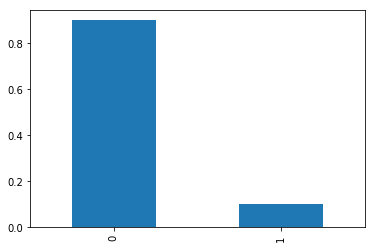

In [9]:
print(data['Col2'].value_counts())
(data['Col2'].value_counts()/np.float(len(data))).plot.bar()

In [10]:
print("Number of positive datapoints in X_train", str(len(y_train[y_train==1])))
print("Number of negative datapoints in X_train", str(len(y_train[y_train==0])))
print("Number of positive datapoints in X_test", str(len(y_test[y_test==1])))
print("Number of negative datapoints in X_test", str(len(y_test[y_test==0])))

Number of positive datapoints in X_train 1180
Number of negative datapoints in X_train 10559
Number of positive datapoints in X_test 581
Number of negative datapoints in X_test 5201


## Finding best hyperparameters for applying Xgboost 

In [0]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

from xgboost import XGBClassifier
from scipy.stats import randint, uniform

def get_best_estimator_xgboost(X_cv, y_cv):
    clf_xgb = XGBClassifier(objective = 'binary:logistic', scale_pos_weight=9)
    param_dist = {'n_estimators': [100, 200,300, 500],
              'learning_rate': [0.01, 0.1, 0.9],
              # 'subsample': uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': [0.1,0.3,0.5,1],
              # 'min_child_weight': [1, 2, 3]
             }
    clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, scoring = 'f1_weighted', error_score = 0, verbose=20, n_jobs = -1, cv=2)
    clf.fit(X_cv, y_cv)
    return clf


In [0]:
%%time 
best_clf = get_best_estimator_xgboost(X_train, y_train)

In [0]:
best_clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=9, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
def apply_xgboost(x_train_data, y_train_data, X_test = X_test, y_test = y_test):
    
    if isinstance(x_train_data, pd.core.frame.DataFrame):
        x_train_data = x_train_data.to_numpy()
    if isinstance(y_train_data, pd.core.frame.DataFrame) or isinstance(y_train_data, pd.core.frame.Series):    
        y_train_data = y_train_data.to_numpy()
    if isinstance(X_test, pd.core.frame.DataFrame):
        X_test = X_test.to_numpy()
    if isinstance(y_test, pd.core.frame.DataFrame) or isinstance(y_test, pd.core.frame.Series):    
        y_test = y_test.to_numpy()

    # x_cfl=XGBClassifier(subsample= 1, n_estimators= 200, max_depth= 5, learning_rate= 0.15, colsample_bytree= .5)
    x_cfl = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.9, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, seed=None, 
              # scale_pos_weight=9,
              silent=None, subsample=1, verbosity=1)
    x_cfl.fit(x_train_data, y_train_data)
    y_test_pred = x_cfl.predict_proba(X_test)

    # plot to find the best threshold for getting best f1 score
    r = (np.arange(0, 1, 0.001))
    f_score = [f1_score(y_test, (y_test_pred[:, 1]> i).astype(bool), average='weighted') for i in r]
    print("Max score obtained: ", str(max(f_score)), " at threshold: ", str(r[f_score.index(max(f_score))]))
    plt.plot(r, f_score)

    plt.title('Finding best threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Weighted f1 score')
    return x_cfl



## Applying Xgboost on Train data without any balancing

Max score obtained:  0.8637372319171283  at threshold:  0.47900000000000004
CPU times: user 2min 4s, sys: 48.6 ms, total: 2min 4s
Wall time: 2min 4s


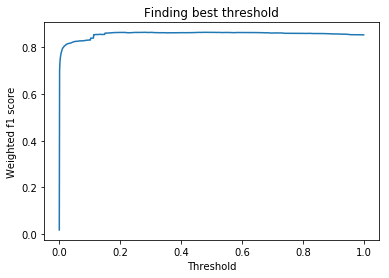

In [17]:
%%time
clf = apply_xgboost(X_train, y_train)

## SMOTE

Max score obtained:  0.8664674955783674  at threshold:  0.657
CPU times: user 4min 27s, sys: 1.68 s, total: 4min 29s
Wall time: 4min 29s


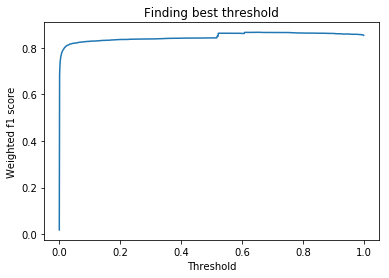

In [18]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_sample(X_train, y_train)
clf_sm = apply_xgboost(X_smote, y_smote)

## Smote NN

Number of points in each class after resampling
[(0, 6106), (1, 9424)]
Max score obtained:  0.8697041902904986  at threshold:  0.975


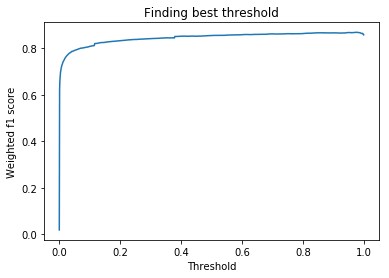

In [19]:
# SMOTE NN
from collections import Counter
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_smotenn, y_smotenn = smote_enn.fit_resample(X_train, y_train)
print("Number of points in each class after resampling")
print(sorted(Counter(y_smotenn).items()))
clf_snn = apply_xgboost(X_smotenn, y_smotenn)

## Smote Tomek

Number of points in each class after resampling
[(0, 10506), (1, 10506)]
Max score obtained:  0.865053033537086  at threshold:  0.65


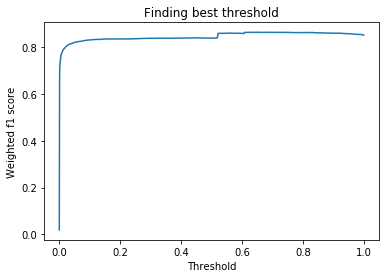

In [20]:
# Tomek sampling
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_tomek, y_tomek = smote_tomek.fit_resample(X_train, y_train)
print("Number of points in each class after resampling")
print(sorted(Counter(y_tomek).items()))
clf_tomek = apply_xgboost(X_tomek, y_tomek)

## Near Miss1 (under sampling)

Number of points in each class after resampling
[(0, 1180), (1, 1180)]
Max score obtained:  0.3851442416093018  at threshold:  0.999


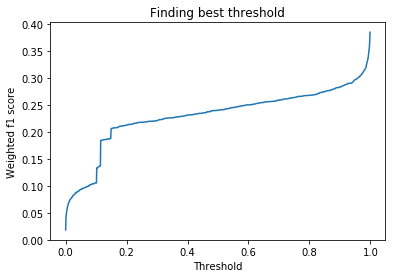

In [21]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
X_nm1, y_nm1 = nm.fit_resample(X_train, y_train)
print("Number of points in each class after resampling")
print(sorted(Counter(y_nm1).items()))
clf_nm1 = apply_xgboost(X_nm1, y_nm1)

## Adasyn oversampling

Number of points in each class after resampling
[(0, 10559), (1, 10279)]
Max score obtained:  0.8635940883824069  at threshold:  0.6
CPU times: user 4min 40s, sys: 959 ms, total: 4min 41s
Wall time: 4min 42s


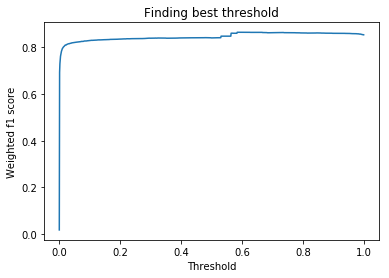

In [22]:
%%time
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_adas, y_adas = ada.fit_resample(X_train, y_train)
print("Number of points in each class after resampling")
print(sorted(Counter(y_adas).items()))
clf_adas = apply_xgboost(X_adas, y_adas)

## Borderline SMOTE

Number of points in each class after resampling
[(0, 10559), (1, 10559)]
Max score obtained:  0.8636845922648637  at threshold:  0.855
CPU times: user 4min 36s, sys: 1.14 s, total: 4min 37s
Wall time: 4min 38s


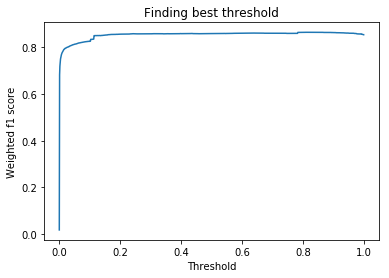

In [23]:
%%time
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
X_sm_br, y_sm_br = sm.fit_resample(X_train, y_train)
print("Number of points in each class after resampling")
print(sorted(Counter(y_sm_br).items()))
clf_sm_br = apply_xgboost(X_sm_br, y_sm_br)

## SVM SMOTE

Number of points in each class after resampling
[(0, 10559), (1, 10559)]
Max score obtained:  0.8658229431474004  at threshold:  0.72
CPU times: user 6min 37s, sys: 2.33 s, total: 6min 39s
Wall time: 6min 40s


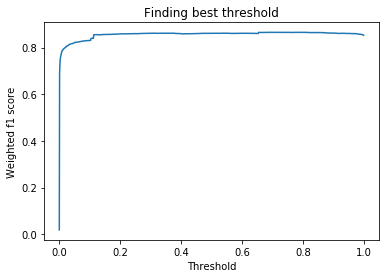

In [24]:
%%time
from imblearn.over_sampling import SVMSMOTE
svm_sm = SVMSMOTE(random_state=42)
X_svm, y_svm = svm_sm.fit_resample(X_train, y_train)
print("Number of points in each class after resampling")
print(sorted(Counter(y_svm).items()))
clf_svm_sm = apply_xgboost(X_svm, y_svm)

## Undersmapling(InstanceHardnessThreshold) + SMOTE

In [7]:
%%time
from imblearn.under_sampling import InstanceHardnessThreshold
rus = InstanceHardnessThreshold(sampling_strategy=0.16)
X_rus, y_rus = rus.fit_sample(X_train, y_train)
print("Number of points in each class after undersampling")
print(sorted(Counter(y_rus).items()))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Number of points in each class after undersampling
[(0, 7662), (1, 1180)]
CPU times: user 1min 55s, sys: 40.9 ms, total: 1min 55s
Wall time: 1min 55s


Number of points in each class after oversampling
[(0, 7662), (1, 7662)]
Max score obtained:  0.8698656814077103  at threshold:  0.999
CPU times: user 2min 50s, sys: 587 ms, total: 2min 51s
Wall time: 2min 51s


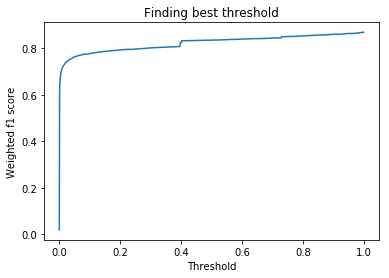

In [10]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_rus_sm, y_rus_sm = smote.fit_sample(X_rus, y_rus)
print("Number of points in each class after oversampling")
print(sorted(Counter(y_rus_sm).items()))
clf_rus_sm = apply_xgboost(X_rus_sm, y_rus_sm)

## Undersampling(AllKNN) + SMOTE

In [11]:
%%time
from imblearn.under_sampling import AllKNN

rus2 = AllKNN()
X_rus2, y_rus2 = rus2.fit_sample(X_train, y_train)

print("Number of points in each class after undersampling")
print(sorted(Counter(y_rus2).items()))

Number of points in each class after undersampling
[(0, 7702), (1, 1180)]
CPU times: user 2min 55s, sys: 103 ms, total: 2min 55s
Wall time: 2min 55s


Number of points in each class after oversampling
[(0, 7702), (1, 7702)]
Max score obtained:  0.8598854390914173  at threshold:  0.75
CPU times: user 2min 54s, sys: 721 ms, total: 2min 55s
Wall time: 2min 55s


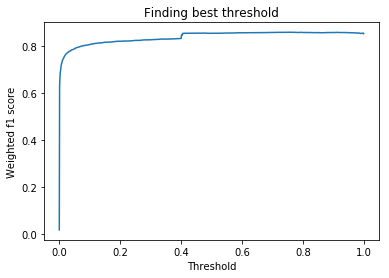

In [12]:
%%time
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
X_rus_sm2, y_rus_sm2 = smote.fit_sample(X_rus2, y_rus2)
print("Number of points in each class after oversampling")
print(sorted(Counter(y_rus_sm2).items()))
clf_rus_sm2 = apply_xgboost(X_rus_sm2, y_rus_sm2)

## Undersampling(NearMiss) + SMOTE

Number of points in each class after undersampling
[(0, 7375), (1, 1180)]
Number of points in each class after oversampling
[(0, 7375), (1, 7375)]
Max score obtained:  0.81625021343617  at threshold:  0.999
CPU times: user 3min 3s, sys: 740 ms, total: 3min 4s
Wall time: 3min 4s


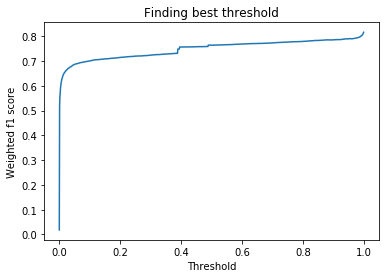

In [13]:
%%time
from imblearn.under_sampling import NearMiss
us_re = NearMiss(sampling_strategy=0.16)
X_us_re, y_us_re = us_re.fit_sample(X_train, y_train)
print("Number of points in each class after undersampling")
print(sorted(Counter(y_us_re).items()))
smote = SMOTE(random_state=0)
X_us_re, y_us_re = smote.fit_sample(X_us_re, y_us_re)
print("Number of points in each class after oversampling")
print(sorted(Counter(y_us_re).items()))
clf_us_re = apply_xgboost(X_us_re, y_us_re)

# Observations
1. Most of the datasets found in the real world problems are unbalanced datasets.
2. IMBLEARN is the python library which has many techniques to balance the dataset.
3. This study focuses on comparision of various techniques which are used to balance the data.
4. In this case, various undersampling, oversampling, and combined methods are used to solve the problem by obtaining maximum weighted f1 score on the test data. Results are tabulated below

In [15]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Sampling Technique", "weighted f1 score"]

x.add_row(["Without using any balancing ", 0.86373])
x.add_row(["SMOTE(oversampling)", 0.86646])
x.add_row(["SMOTENN(oversampling+KNN cleaning)", 0.869704])
x.add_row(["SMOTETomek(oversampling)", 0.86505])
x.add_row(["SVM SMOTE(oversampling)", 0.86582])
x.add_row(["NearMiss(undersampling)", 0.38514])
x.add_row(["ADASYN(oversampling)", 0.86359])
x.add_row(["BorderLine SMOTE(oversampling)", 0.86368])
x.add_row(["Undersmapling(InstanceHardnessThreshold) + oversampling(SMOTE)", 0.86986])
x.add_row(["Undersmapling(AllKNN) + oversampling(SMOTE)", 0.85988])
x.add_row(["Undersmapling(NearMiss) + oversampling(SMOTE)", 0.81625])


print(x)

+----------------------------------------------------------------+-------------------+
|                       Sampling Technique                       | weighted f1 score |
+----------------------------------------------------------------+-------------------+
|                  Without using any balancing                   |      0.86373      |
|                      SMOTE(oversampling)                       |      0.86646      |
|               SMOTENN(oversampling+KNN cleaning)               |      0.869704     |
|                    SMOTETomek(oversampling)                    |      0.86505      |
|                    SVM SMOTE(oversampling)                     |      0.86582      |
|                    NearMiss(undersampling)                     |      0.38514      |
|                      ADASYN(oversampling)                      |      0.86359      |
|                 BorderLine SMOTE(oversampling)                 |      0.86368      |
| Undersmapling(InstanceHardnessThreshold) 

# References
https://www.kaggle.com/getting-started/100018

https://github.com/pb111/Data-Preprocessing-Project-Imbalanced-Classes-Problem

https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    
https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/